In [50]:
import numpy as np
import matplotlib.pyplot as plt
import random
from numpy import linalg as LA

Setting a bunch of parameters first!

In [51]:
hbar = 1 *1e-34

def print_section():
    print("---------------------------------------------------------------------------------------------------------------------")
    return None
random.seed(95757) #Seed for reproducibility
T = 10 * 1e-3
kb = 1.38*1e-23
kappa = 0.248;
z0 = 3/4*2.7*1e-3;
r0 = 3/4*3.5*1e-3;
a1 = -0.001;
q1 = 0.21801801801801804;
omega_RF = 2*np.pi*5.2*1e6;
m1 = 135*1.66*(10**(-27))
m2 = 9000*1.66*(10**(-27))
Q1 = 1*1.6*1e-19;
Q2 = 24*1.6*1e-19;
omega_z1 = omega_RF*np.sqrt(-a1/2)
omega_r1 = omega_RF/2*np.sqrt(q1**2/2+a1)
V_DC = -a1*m1*(3/4*2.7*1e-3)**2*omega_RF**2/(4*Q1*0.248)
V_RF = q1/(2*Q1)*(m1*r0**2*omega_RF**2)
c = 3*1e8
lambd = c/(607.426262*1e12)
alpha = 0.1 #0.5 for radial degeneracy
waist = 500*1e-6
epsilon0 = 8.85*1e-12

rho = Q2/Q1
mu = m2/m1

a2 = rho/mu * a1
q2 = rho/mu * q1

omega_z2 = omega_RF*np.sqrt(-a2/2)

omega_pond_1 = Q1*V_RF/(np.sqrt(2)*omega_RF*m1*r0**2)
omega_x1 = np.sqrt(omega_pond_1**2 - alpha*omega_z1**2)
omega_y1 = np.sqrt(omega_pond_1**2-(1-alpha)*omega_z1**2)

omega_pond2 = Q2*V_RF/(np.sqrt(2)*omega_RF*m2*r0**2)
omega_x2 = np.sqrt(omega_pond2**2-alpha*omega_z2**2)
omega_y2 = np.sqrt(omega_pond2**2-(1-alpha)*omega_z2**2)

zeq1 = np.cbrt(Q1*Q2/(4*np.pi*epsilon0*m1*omega_z1**2)*(1/(1+1/rho)**2))
zeq2 = -1/rho * zeq1
V_tickle = 0.5*V_DC
print_section()
print("DC Voltage: ",V_DC)
print("RF Voltage: ", V_RF )
print("Tickle Voltage: ", V_tickle)
print_section()
print("Equilibrium positions (µm): " , "z1 = ", zeq1 * 1e6, "    z2 = " ,zeq2 * 1e6)

---------------------------------------------------------------------------------------------------------------------
DC Voltage:  6.180543690435875
RF Voltage:  1123.0764095042432
Tickle Voltage:  3.0902718452179374
---------------------------------------------------------------------------------------------------------------------
Equilibrium positions (µm):  z1 =  34.91569982716426     z2 =  -1.4548208261318443


Now solve the 2nd order eigenproblem!

In [52]:
deltaZ = zeq1-zeq2
K11 = omega_z1**2 + Q1*Q2/(4*np.pi*epsilon0*m1) * (2/deltaZ**3)
K12 = -Q1*Q2/(4*np.pi*epsilon0*np.sqrt(m1*m2)) * (2/deltaZ**3)
K22 = omega_z2**2 + Q1*Q2/(4*np.pi*epsilon0*m2) * (2/deltaZ**3)

K33 = omega_x1**2 - Q1*Q2/(4*np.pi*epsilon0*m1) * (1/deltaZ**3)
K34 = -0.5*K12
K44 = omega_x2**2 - Q1*Q2/(4*np.pi*epsilon0*m2) * (1/deltaZ**3)

K55 = omega_y1**2 - Q1*Q2/(4*np.pi*epsilon0*m1) * (1/deltaZ**3)
K56 = K34
K66 = omega_y2**2 - Q1*Q2/(4*np.pi*epsilon0*m2) * (1/deltaZ**3)

KZ = np.array([[K11,K12],[K12,K22]])
KY = np.array([[K33,K34],[K34,K44]])
KX = np.array([[K55,K56],[K56,K66]])


z_freqs, z_vecs = LA.eig(KZ)
y_freqs, y_vecs = LA.eig(KY)
x_freqs, x_vecs = LA.eig(KX)

z_freqs = np.sqrt(z_freqs)
y_freqs = np.sqrt(y_freqs)
x_freqs = np.sqrt(x_freqs)

print_section()
print("z frequencies are (kHz) : ", (z_freqs[0])/(2*np.pi*1e3),"     ", (z_freqs[1])/(2*np.pi*1e3))
print("z eigenvectors are: ", z_vecs[:,0], "        ", z_vecs[:,1])
print_section()
print("x frequencies are (kHz) : ", (x_freqs[0])/(2*np.pi*1e3),"     ", (x_freqs[1])/(1*np.pi*1e3))
print("x eigenvectors are: ", x_vecs[:,0], "        ", x_vecs[:,1])
print_section()
print("y frequencies are (kHz) : ", (y_freqs[0])/(2*np.pi*1e3),"     ", (y_freqs[1])/(1*np.pi*1e3))
print("y eigenvectors are: ", y_vecs[:,0], "        ", y_vecs[:,1])
print_section()

#Remember to include z-tickle in radial direction as well.

---------------------------------------------------------------------------------------------------------------------
z frequencies are (kHz) :  199.42730185869792       70.45372433987998
z eigenvectors are:  [ 0.99578443 -0.09172445]          [0.09172445 0.99578443]
---------------------------------------------------------------------------------------------------------------------
x frequencies are (kHz) :  368.14624466186456       254.7538652710156
x eigenvectors are:  [0.99991122 0.01332499]          [-0.01332499  0.99991122]
---------------------------------------------------------------------------------------------------------------------
y frequencies are (kHz) :  382.5526052293376       283.6885944729587
y eigenvectors are:  [0.99992069 0.01259438]          [-0.01259438  0.99992069]
---------------------------------------------------------------------------------------------------------------------


Now we write a function for calculating the force a charged particle feels in the trap!

In [53]:
def TrapForce(q,r,V_DC,V_RF,t):
    #r is 3d vector (x,y,z)
    z = r[2]
    x = r[0]
    y = r[1]
    Fz = q*-2*kappa*V_DC/(z0**2) * z
    Fy = q*(kappa*V_DC/(z0**2) *y -V_RF/(r0**2)*y*np.cos(omega_RF*t))
    Fx = q*(kappa*V_DC/(z0**2) *x +V_RF/(r0**2)*x*np.cos(omega_RF*t))
    return  np.array([Fx,Fy,Fz])

Everything is in place. Let us do a simple velocity-verlet integration to check everything works.

In [54]:
r_init = np.ones(3)*100*1e-6
v_init = np.zeros(3)
t_init = 0
t_end = 5*1e-5

dt = 2*np.pi/(omega_RF)/500

t = 0
ts = []
positions = []
velocities = []
print("Initial Time: ", t_init)
print("End Time: ", t_end)
print("Time Step: ", dt)
print("Total number of steps: ",np.floor(t_end/dt))
print_section()
print("Initial position (µm): ", r_init*1e6)
print("Initial velcoity (m/s): ", v_init)

print_section()
print("Secular z-direction Barium Frequency (kHz):  ", omega_z1/(2*np.pi*1e3))
print("Secular x-direction Barium Frequency (kHz):  ", omega_y1/(2*np.pi*1e3))
print("Secular y-direction Barium Frequency (kHz):  ", omega_x1/(2*np.pi*1e3))
print_section()


Initial Time:  0
End Time:  5e-05
Time Step:  3.846153846153846e-10
Total number of steps:  130000.0
---------------------------------------------------------------------------------------------------------------------
Initial position (µm):  [100. 100. 100.]
Initial velcoity (m/s):  [0. 0. 0.]
---------------------------------------------------------------------------------------------------------------------
Secular z-direction Barium Frequency (kHz):   116.27553482998908
Secular x-direction Barium Frequency (kHz):   385.3435790176169
Secular y-direction Barium Frequency (kHz):   399.131148734481
---------------------------------------------------------------------------------------------------------------------


In [55]:
current_pos = r_init
current_vel = v_init
counter = 0
while t < t_end:
    next_t = t+dt
    next_pos = current_pos+current_vel*dt+1/(m1*2)*TrapForce(Q1,current_pos,V_DC,V_RF,t)*dt**2
    next_force = TrapForce(Q1,next_pos,V_DC,V_RF,next_t)
    next_vel = current_vel+1/(2*m1)*(TrapForce(Q1,current_pos,V_DC,V_RF,t)+next_force)*dt
    
    if np.mod(counter,500) == 0:
        ts.append(t)
        positions.append(current_pos)
        velocities.append(current_vel)

    t+=dt
    current_pos=next_pos
    current_vel=next_vel
    counter +=1

Text(0.5, 0, 'Time (ms)')

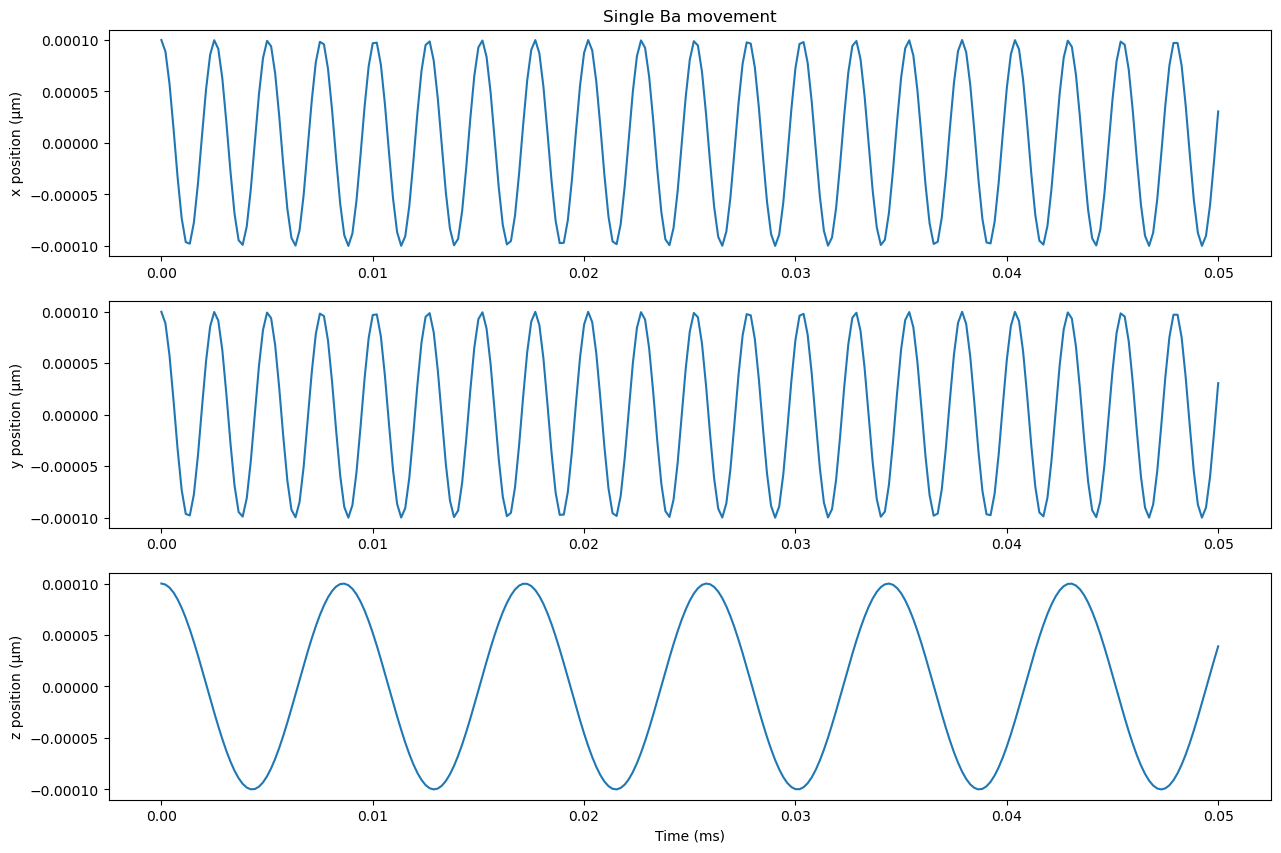

In [61]:
fig,ax = plt.subplots(3,1,figsize = (15,10))
zs = []
ys = []
xs = []
for position in positions:
    zs.append(position[2])
    ys.append(position[1])
    xs.append(position[0])

ax[0].plot(np.array(ts)*1e3,xs)
ax[1].plot(np.array(ts)*1e3,ys)
ax[2].plot(np.array(ts)*1e3,zs)

ax[0].set_ylabel('x position (µm)')
ax[1].set_ylabel('y position (µm)')
ax[2].set_ylabel('z position (µm)')
ax[0].set_title('Single Ba movement')
ax[2].set_xlabel('Time (ms)')